# Variational Quantum Algorithm

In [90]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [91]:
hamiltonian = SparsePauliOp.from_list(
    [("XX", 1), ("YY", 1), ("ZI", 1)]
)

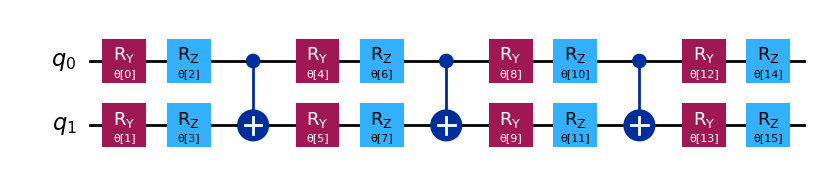

In [92]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [93]:
num_params = ansatz.num_parameters
num_params

16

In [94]:
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2

# Define Aer simulator backend
backend = AerSimulator()
estimator = EstimatorV2(
    options={
        "run_options": {"shots": 1024, "seed": 28}
    }
)

In [95]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

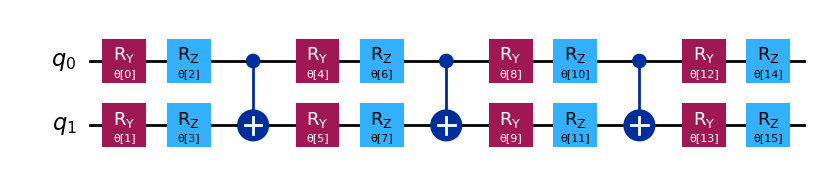

In [96]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [97]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [98]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [99]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [100]:
x0 = 2 * np.pi * np.random.random(num_params)

In [101]:
x0

array([5.55251546, 2.97858567, 3.17610225, 3.14920369, 1.32787999,
       4.95481257, 5.17489779, 6.14928524, 1.33368949, 3.34637323,
       2.84536895, 3.30564862, 5.95604874, 2.7774286 , 1.58440623,
       5.93299907])

In [102]:
from scipy.optimize import minimize

# Perform the optimization using Aer simulator
res = minimize(
    cost_func,  # Function to minimize
    x0,  # Initial guess for parameters
    args=(ansatz_isa, hamiltonian_isa, estimator),  # Arguments for cost function
    method="COBYLA",  # Optimization method
)
            

Iters. done: 1 [Current cost: 1.5135884826289414]
Iters. done: 2 [Current cost: 0.2700413499039352]
Iters. done: 3 [Current cost: 0.5813666943879395]
Iters. done: 4 [Current cost: 0.4244578390548098]
Iters. done: 5 [Current cost: 0.3935796306712655]
Iters. done: 6 [Current cost: 0.11971167651651943]
Iters. done: 7 [Current cost: -0.2636342857799926]
Iters. done: 8 [Current cost: -0.39873161476817415]
Iters. done: 9 [Current cost: -0.33854379374226024]
Iters. done: 10 [Current cost: 0.413291493032693]
Iters. done: 11 [Current cost: 0.22516665726555973]
Iters. done: 12 [Current cost: -0.43601956605071174]
Iters. done: 13 [Current cost: -0.5679887153519267]
Iters. done: 14 [Current cost: -0.279072820521291]
Iters. done: 15 [Current cost: -0.7210164016957632]
Iters. done: 16 [Current cost: -0.530004600246333]
Iters. done: 17 [Current cost: -0.4363394504613716]
Iters. done: 18 [Current cost: -0.6761745658166988]
Iters. done: 19 [Current cost: -0.6239759695421251]
Iters. done: 20 [Current co

In [103]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.23606795588046
       x: [ 6.651e+00  3.218e+00 ...  1.466e+00  5.562e+00]
    nfev: 316
   maxcv: 0.0

In [104]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [105]:
cost_history_dict["iters"] == res.nfev

True

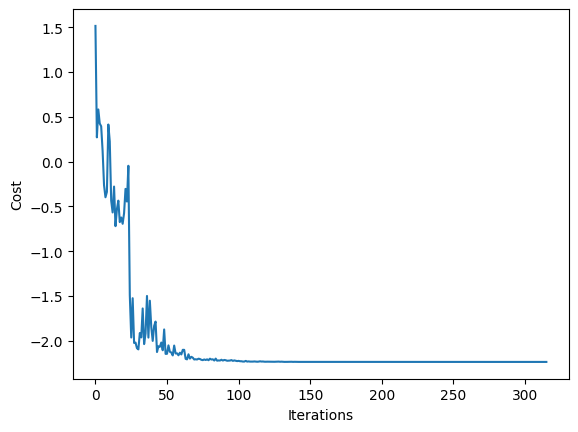

In [106]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [107]:
from qiskit_algorithms import NumPyMinimumEigensolver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(hamiltonian)

In [108]:
print('Optimized ground state energy:', res.fun)
print('Exact ground state energy:', exact_result.eigenvalue.real)
print('Energy Difference:', abs(exact_result.eigenvalue.real - res.fun))

Optimized ground state energy: -2.23606795588046
Exact ground state energy: -2.2360679774997885
Energy Difference: 2.1619328549604688e-08
